<a href="https://colab.research.google.com/github/InhuKim/AI_proj_Team2/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
time_series = pd.DataFrame()
target_label = pd.DataFrame()

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/data/meta_data/train'
count = 0
row = pd.DataFrame()

for i in range(75):
    if i + 1 < 10:
        i_str = '0' + str(i +1)
    elif i + 1 > 10:
        i_str = str(i +1)
    elif i + 1 == 10:
        i_str = str(i + 1)

    file_list = os.listdir(path + '/CASE' + i_str)
    file_list_py = [file for file in file_list if file.endswith('.csv')]

    for l in file_list_py:
        data = pd.read_csv(path + '/CASE' + i_str + '/' + l)
        time_series = pd.concat([time_series, data])

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/data/meta_data/target'
count2 = 0

for j in range(75):
    if j + 1 < 10:
        j_str = '0' + str(j +1)
    elif j + 1 > 10:
        j_str = str(j +1)
    elif j + 1 == 10:
        j_str = str(j + 1)

    file_list = os.listdir(path + '/CASE' + j_str)
    file_list_py = [file for file in file_list if file.endswith('.csv')]

    for k in file_list_py:
        target = pd.read_csv(path + '/CASE' + j_str + '/' + k)
        target_label = pd.concat([target_label, target])

In [ ]:
print(len(target_label))
print(len(time_series) / 1440)

1284
1292.0


In [ ]:
# time_series = time_series[['내부온도관측치', '내부습도관측치', 'CO2관측치', '최근분무량','냉방온도', '난방온도']]

In [ ]:
target_dataset = target_label.to_numpy()
target_dataset = target_dataset[:, 1]

In [ ]:
time_dataset = time_series.to_numpy()
time_dataset = time_dataset[:, 1:]

In [ ]:
time_dataset.shape

(1860480, 18)

In [ ]:
def sliding_windows(data, target):
    x = []
    y = []

    for i in range(len(target)):
        _x = data[(i * 1440): ((i + 1) * 1440)]
        _y = target[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc_df = MinMaxScaler()
# sc_t = MinMaxScaler()
training_data = sc_df.fit_transform(time_dataset)
# target_data = sc_t.fit_transform(target_dataset.reshape(-1, 1))


x, y = sliding_windows(training_data, target_dataset)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x))).to(device)
trainY = Variable(torch.Tensor(np.array(y))).to(device)

testX = Variable(torch.Tensor(np.array(x[1020:1275]))).to(device)
testY = Variable(torch.Tensor(np.array(y[1020:1275]))).to(device)

In [ ]:
print(dataX.shape)
print(trainY.shape)
print(testX.shape)

train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

torch.Size([1284, 1440, 18])
torch.Size([1284])
torch.Size([255, 1440, 18])


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# 일반 LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=bidirectional).to(device)
        
        self.fc = nn.Linear(hidden_size *2, 256).to(device)
        self.fc2 = nn.Linear(256, 1).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers *2, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers *2, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
                
        out = self.fc(h_out.view(-1, self.hidden_size*2))
        out = self.fc2(out)
        
        return out

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(RNN, self).__init__()
        
        self.RNN = nn.RNN(input_size = input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size *2, 1)
        self.fc2 = nn.Linear(1440, 1)
        
        
    def forward(self, x):
        x, _ = self.RNN(x)
        x = self.fc(x)
        x = torch.flatten(x, start_dim=1)
        out = self.fc2(x)
        
        return out

In [ ]:
a = torch.tensor(np.arange(8*1440*18).reshape(8, 1440, 18), dtype=torch.float32).to(device)
print(a.shape)

torch.Size([8, 1440, 18])


In [ ]:
model = LSTM(18, 512, 1, True)
out = model(a)
print(out.squeeze(1).shape)

torch.Size([8])


In [ ]:
for i in train_dataloader:
    x, y = i
    print(x.shape)
    print(y.shape)
    out = model(x)
    out2 = torch.squeeze(out)
    print(out2.shape)
    print(y.shape)
    break

torch.Size([20, 1440, 18])
torch.Size([20])
torch.Size([20])
torch.Size([20])


In [ ]:
def validation(model, vali_loader, criterion, device):
    model.eval()
    vali_loss = []

    with torch.no_grad():
        for idx, sample in enumerate(vali_loader):
            x_vali, y_vali = sample

            out = model(x_vali)
            loss = criterion(out, y_vali)
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [ ]:
num_epochs = 50
learning_rate = 0.003

input_size = 18
hidden_size = 512
num_layers = 1

best_mae = 9999

model = LSTM(input_size, hidden_size, num_layers, bidirectional=True).to(device)

criterion = torch.nn.L1Loss().to(device)    # mean-squared error for regression
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_plot = []
vali_loss_plot = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for batch_idx, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        
        optimizer.zero_grad()
        outputs = model(x_train)
        out = torch.squeeze(outputs)
    
        # obtain the loss function
        loss = criterion(out, y_train)
    
        loss.backward()
    
        optimizer.step()

        train_loss.append(loss.item())

        # validation
    vali_mae = validation(model, test_dataloader, criterion, device)
    vali_loss_plot.append(vali_mae)

    print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
    vali_loss_plot.append(vali_mae)
    train_loss_plot.append(np.mean(train_loss))

    if best_mae > vali_mae:
        best_mae = vali_mae
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/competition/meta_LSTM_full_feature.pth')
        print('model saved.')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [0] Train MAE : [81.42246] Validation MAE : [85.77097]

model saved.
Epoch [1] Train MAE : [80.61663] Validation MAE : [85.42286]

model saved.
Epoch [2] Train MAE : [80.36885] Validation MAE : [85.02014]

model saved.
Epoch [3] Train MAE : [79.94500] Validation MAE : [84.53270]

model saved.
Epoch [4] Train MAE : [79.90925] Validation MAE : [83.93952]

model saved.
Epoch [5] Train MAE : [78.42036] Validation MAE : [83.15953]

model saved.
Epoch [6] Train MAE : [78.00048] Validation MAE : [82.12045]

model saved.
Epoch [7] Train MAE : [77.46098] Validation MAE : [80.68768]

model saved.
Epoch [8] Train MAE : [76.14638] Validation MAE : [78.95782]

model saved.
Epoch [9] Train MAE : [75.33761] Validation MAE : [76.93920]

model saved.
Epoch [10] Train MAE : [72.46159] Validation MAE : [75.59797]

model saved.
Epoch [11] Train MAE : [71.10032] Validation MAE : [75.27508]

model saved.
Epoch [12] Train MAE : [72.52404] Validation MAE : [75.22346]

model saved.
Epoch [13] Train MAE :

In [ ]:
valid_loss = pd.DataFrame(vali_loss_plot, index=None)
valid_loss = valid_loss.drop_duplicates()

In [ ]:
valid_loss_plot = valid_loss[0].to_list()
valid_loss_plot

<function matplotlib.pyplot.show>

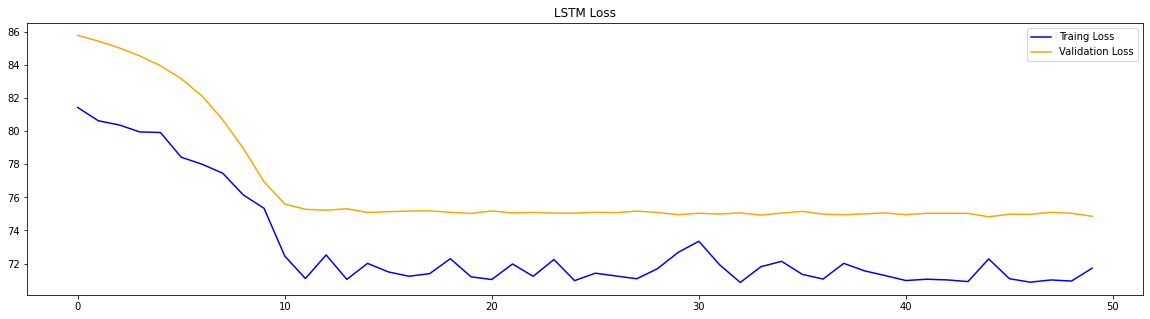

In [ ]:
figure = plt.figure(figsize=(20,5))
ax1 = figure.add_subplot(1,1,1)
ax1.plot(train_loss_plot, label='Traing Loss', color='blue')
ax1.plot(valid_loss_plot, label='Validation Loss', color='orange')
ax1.legend(loc='upper right')
ax1.set_title('LSTM Loss')

plt.savefig('/content/drive/MyDrive/Colab_Notebooks/competition/LSTM_loss.png')
plt.show

# One fully-connected layer after the LSTM

In [ ]:
from torch import nn


class DenseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers=1, bidirectional=False, dense=False):
        super(DenseLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = lstm_layers
        self.bidirectional = bidirectional
        self.dense = dense
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size=self.input_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.layers,
                            bidirectional=self.bidirectional)
        self.act1 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional
        if not bidirectional:
            self.linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        else:
            self.linear = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.act2 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional and extra dense layer isn't added
        if bidirectional and not dense:
            self.final = nn.Linear(self.hidden_dim * 2, 1)
        else:
            self.final = nn.Linear(self.hidden_dim, 1)


    def forward(self, inputs, labels=None):
        out = inputs.unsqueeze(1)
        out, h = self.lstm(out)
        out = self.act1(out)
        if self.dense:
            out = self.linear(out)
            out = self.act2(out)
        out = self.final(out)
        return out

In [ ]:
import time

def fit(model, optimizer, criterion):
    print("{:<8} {:<25} {:<25} {:<25}".format('Epoch', 
                                          'Train Loss', 
                                          'Test Loss', 
                                          'Time (seconds)'))
    for epoch in range(epochs):
        model.train()
        start = time.time()
        epoch_loss = []
        # for batch in train data
        for step, batch in enumerate(train_dataloader):
            # make gradient zero to avoid accumulation
            model.zero_grad()
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            print(inputs.shape)
            # get predictions
            out = model(inputs)
            out.to(device)
            # get loss
            loss = criterion(out, labels)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            # backpropagate
            loss.backward()
            optimizer.step()
        test_epoch_loss = []
        end = time.time()
        model.eval()
        # for batch in validation data
        for step, batch in enumerate(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            # get loss
            loss = criterion(out, labels)     
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        print("{:<8} {:<25} {:<25} {:<25}".format(epoch+1, 
                                                  np.mean(epoch_loss), 
                                                  np.mean(test_epoch_loss), 
                                                  end-start))




In [ ]:
hidden_dim = 32
epochs = 5

model = DenseLSTM(18, hidden_dim, lstm_layers=2, bidirectional=True, dense=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

fit(model, optimizer, criterion)

# 평가

In [ ]:
model.eval()
test_predict = model(testX)
numpy_test = test_predict.cpu().detach().numpy()

# data_predict = test_predict.data.numpy()
# dataY_plot = testY.data.numpy()

# data_predict = sc_t.inverse_transform(data_predict)
# dataY_plot = sc_t.inverse_transform(dataY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot)
# plt.plot(data_predict)
# plt.suptitle('Time-Series Prediction')
# plt.show()
numpy_test

In [ ]:
data_predict = sc_t.inverse_transform(numpy_test)

In [ ]:
data_predict

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/data/test/meta/'
test = pd.DataFrame()

file_list = os.listdir(path)

for l in file_list:
    data = pd.read_csv(path + l)
    test = pd.concat([test, data])

In [ ]:
test = test[['내부온도관측치', '내부습도관측치', 'CO2관측치', '최근분무량','냉방온도', '난방온도']]
test = test.fillna(method='bfill')
test = test.fillna('0')
print(test.shape)

(662400, 6)


In [ ]:
test

In [ ]:
test_dataset = test.to_numpy()
test_dataset = test_dataset[:, :]
print(test_dataset.shape)

(662400, 6)


In [ ]:
test_dataset

array([[24.89999961853028, 21.600000381469727, 47.59999847412109, ...,
        309.41, 16.548000000000002, 29.7635],
       [24.799999237060547, 21.600000381469727, 48.400001525878906, ...,
        309.41, 16.548000000000002, 29.7635],
       [24.5, 21.700000762939453, 49.400001525878906, ..., 309.41,
        16.548000000000002, 29.7635],
       ...,
       [25.6000003814697, 25.8999996185302, 83.6999969482421, ..., 0.0,
        0.0, 0.0],
       [25.5, 25.8999996185302, 83.6999969482421, ..., 0.0, 0.0, 0.0],
       [25.5, 25.8999996185302, 83.6999969482421, ..., 0.0, 0.0, 0.0]],
      dtype=object)

In [ ]:
len(test_dataset)/1440
test_dataset.shape

(662400, 6)

In [ ]:
def test_windows(data):
    x = []

    for i in range(int(len(data)/1440)):
        _x = data[(i * 1440): ((i + 1) * 1440)]
        x.append(_x)

    return np.array(x)

sc_real = MinMaxScaler()
testing_data = sc_df.fit_transform(test_dataset)

t = test_windows(testing_data)

test_T = Variable(torch.Tensor(np.array(t))).to(device)
test_set = DataLoader(test_T, batch_size=20, shuffle=False)

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for sample in tqdm(iter(test_loader)):
            meta = sample.float().to(device)

            pred_logit = model(sample)
            pred_logit = pred_logit.detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab_Notebooks/competition/meta_LSTM.pth')
model = LSTM(6, 512, 1, bidirectional=True).to(device)

test_predict = predict(model, test_set, device)


test_predict

In [ ]:
test_predict2 = np.array(test_predict)
test_predict2.shape

(460, 1)

In [ ]:
out = sc_t.inverse_transform(test_predict)

In [ ]:
out

In [ ]:
submission = pd.read_csv('./data/open/sample_submission.csv')
submission['leaf_weight'] = data_predict
submission.to_csv('./submit_lstm2.csv', index=False)